In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.utils.data
import torch.distributions
from PIL import Image
from texture_vae.models.texture_vae import Autoencoder
import texture_vae.utils.texture_dataset as dataset
from torchsummary import summary
import os
import torchvision
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from  torch.optim.lr_scheduler import CyclicLR
%matplotlib inline
import time
from IPython import display

# Texture Stiching using Gradient Descent

Our VAE model can be used beyond simple sampling. Since the image generation is now fully differentiateable, we can guide the image synthesis towards an objective.

A good example is texture stiching. 
Our tiles of 128x128 pixels have a very low resolution and show only a subset of a pattern (e.g. only a few bricks).

Unfortunately, simple tiling shows obvious seams and repetitions.

However, using our generative model, we can partially overlap each tile and make sure the overlapping regions are as similar as possible.


<div style="column-count: 2; column-gap: 100px;">
    <div style="display: inline-block;">
        <h2>Simple Tiling</h2>
        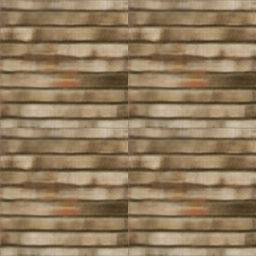
    </div>
    <div style="display: inline-block;">
        <h2>Optimized Stiching</h2>
          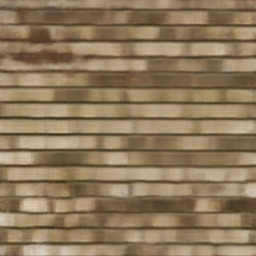
    </div>
</div>

## Constants

In [2]:
TEXTURE_SIZE = 128
LATENT_DIMS = 32
DEVICE="cpu"

## Model Loading

Load the model, its weights and setup Dataloader

In [3]:
def load_model(snapshot_fn:str, latent_dims: int, texture_size:int):
    autoencoder = Autoencoder(latent_dims=latent_dims, image_size=texture_size, device=DEVICE)
    autoencoder.load_state_dict(torch.load(snapshot_fn))
    return autoencoder.to(DEVICE)

In [4]:
def show_samples(sampled_images, dpi=150):
    plt.rcParams["savefig.bbox"] = 'tight'
    plt.rcParams['figure.dpi'] = dpi
    plt.axis('off')
    from torchvision.utils import make_grid
    import torchvision.transforms.functional as F
    grid = make_grid(sampled_images)
    grid = F.to_pil_image(grid)
    plt.imshow(grid)
    plt.show()

In [5]:
def sample_around(latent, num_samples: int):
    with torch.inference_mode():
        seed_image = ae.sample(latent)
        x_rec, mu, logvar,_ = ae(seed_image)
        z = latent + torch.normal(mu.repeat(num_samples,1), torch.exp(logvar).repeat(num_samples,1))
        print(z)
        return ae.sample(z + 0.5*torch.randn(4,16))

In [6]:
def create_texture(target_width:int, target_height:int, seed_patch: torch.Tensor):
    stitch_result = torch.zeros((3, target_height,target_width))
    overlap = 16
    patch_size =  ae.image_size
    with torch.no_grad():
        stitch_result[:,:patch_size,:patch_size] = seed_patch
    return stitch_result


In [57]:
def _get_overlay_mask(patch: torch.Tensor, overlap:int, target_x:int, target_y:int):
    patch_mask = torch.zeros_like(patch, dtype=torch.int)
    if target_x > 0:
       patch_mask[:,:,:overlap] = 1
    if target_y > 0:
       patch_mask[:,:overlap,:] = 1
    return  patch_mask

def _get_blend_mask(patch: torch.Tensor, overlap:int, target_x:int, target_y:int):
    blend_mask = torch.ones_like(patch, dtype=torch.float)
    if target_x > 0:
        blend_mask[:,:,:overlap] = blend_mask[:,:,:overlap]*torch.linspace(0,1,overlap)
    if target_y > 0:
        factor = torch.linspace(0,1,overlap).repeat(blend_mask.shape[1],1).transpose(0,1)
        blend_mask[:, :overlap, :] = blend_mask[:, :overlap, :] * factor
    return  blend_mask

from typing import Callable

from texture_vae.utils.mmsim import MSSIM
def stich(ae: Autoencoder, epochs:int, texture:torch.Tensor, overlap:int, target_x:int, target_y:int, start_z, post_epoch_cb:Callable= None):
    if start_z is None:
        seed_latent = torch.zeros(1,ae.latent_dims).to(ae.device)
    else:
        seed_latent = start_z.clone()
    patch_latents = nn.Parameter(seed_latent, requires_grad=True)
    opt = torch.optim.Adam(params=[patch_latents], lr=1e-1)
    sim = MSSIM()
    seed_patch = texture[:,:128,:128]
    with tqdm(range(epochs), total=epochs) as tepoch:
        for e in tepoch:
            opt.zero_grad()
            patch = ae.decoder(patch_latents)[0]
            mask = _get_overlay_mask(patch, overlap, target_x, target_y)
            target_patch = texture[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]]
            mssim = sim((target_patch*mask).unsqueeze(0), (patch*mask).unsqueeze(0))
            loss = mssim 
            loss.backward()
            opt.step()
            if post_epoch_cb:
                post_epoch_cb(patch,e)
            tepoch.set_postfix(loss=loss.item())
    target_patch = texture[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]]
    blend_mask = _get_blend_mask(patch, overlap, target_x, target_y)
    texture[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]] = (1-blend_mask)*target_patch +  blend_mask*patch
    return texture.detach(), patch_latents.detach()
    

In [10]:
ae = load_model("../snapshots/texture_vae_lat32_res128_kl5e-4.pth", texture_size=TEXTURE_SIZE, latent_dims=LATENT_DIMS)


## Plot Samples from normal distribution
Generate a few samples and select the correct index later

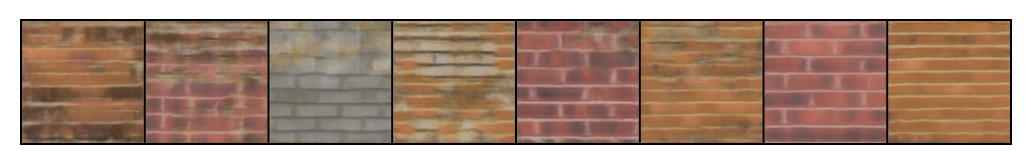

In [102]:
sample_seed = torch.normal(0, 1, (8,ae.latent_dims)).to(ae.device)
sampled_images = ae.sample(sample_seed)
show_samples(sampled_images, 200)

In [96]:
from functools import partial
from pathlib import Path
def save_debug_image(patch: torch.Tensor, epoch:int, target_x: int, target_y:int, texture: torch.Tensor, outdir:Path, counter: dict):
    if epoch % 10 != 0:
        return
    tex = texture.detach().clone()
    tex[:,target_y:target_y+patch.shape[1],target_x:target_x+patch.shape[1]] = patch
    img = F.to_pil_image(tex)
    img.save(outdir/ Path(f"stich_{counter['frame']:04}.jpg"))
    counter["frame"] += 1

Set IMG_IDX to the desired index from the samples

In [97]:
IMG_IDX = 6

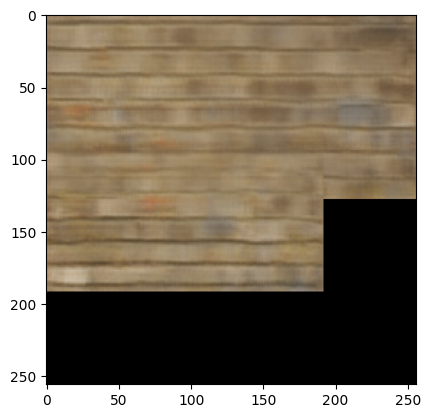

 27%|██▋       | 41/150 [00:01<00:03, 29.42it/s, loss=0.0362]


KeyboardInterrupt: 

In [98]:
# run the optimization
plt.rcParams['figure.dpi'] = 100
tex = create_texture( target_width=128*2, target_height=128*2, seed_patch=sampled_images[IMG_IDX])
img = F.to_pil_image(tex)
plt.imshow(img)
plt.show()
stitch_result = tex.clone()
overlap=64
with torch.no_grad():
    x_hat, mu, logvar, z = ae(sampled_images[IMG_IDX].unsqueeze(dim=0))

outdir = Path("./dbg")
if not outdir.exists():
    outdir.mkdir(exist_ok=True)
frame_counter = {"frame": 0}
for y in range(0,3):
    for x in range(0,3):
        if x ==0 and y==0:
            continue
        stitch_result, _ = stich(ae, 
                                 epochs=150, 
                                 texture=stitch_result.detach(),
                                 overlap=overlap, 
                                 target_x=x*ae.image_size-x*overlap, 
                                 target_y = y*ae.image_size-y*overlap, 
                                 start_z = z, 
                                 post_epoch_cb=partial(save_debug_image, counter=frame_counter, texture=stitch_result.detach(), target_x=x*ae.image_size-x*overlap, target_y=y*ae.image_size-y*overlap,outdir=outdir))
        img = F.to_pil_image(stitch_result)
        display.clear_output(wait=True)
        plt.imshow(img)
        plt.show()